# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/j/anaconda3/bin/python (found version "3.7.4") 
-- Found PythonLibs: /home/j/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/j/UBA/metodosNumericos/hub/metodos-tp2
-- Configuring done
-- Generating done

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/j/UBA/metodosNumericos/hub/metodos-tp2/notebooks
Python 3.7.4


## Explorando los datos

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [4]:
df_train.shape

(42000, 785)

### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [83]:
data_train = df_train[:5000]
#data_test = df_train[5000:7000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [84]:
# Uso values para mandar todo a arrays de numpy
X = data_train[data_train.columns[1:]].values
y = data_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 5


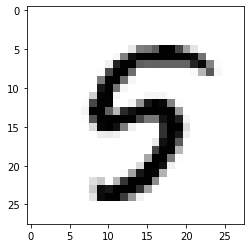

In [85]:
import matplotlib.pyplot as plt

num = 8

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [86]:
data_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
8    0.0954
4    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [87]:
#DATA SPLIT: elijo que porcentaje del total es para training y cual es para Testeo.
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_test)} de testeo")


Ahora tengo 4000 instancias de entrenamiento y 1000 de testeo


In [88]:
def list_mean(list):
    return sum(list)/ len(list)

#  K-Fold Validation


In [89]:
#dividimos los datos de entrenamiento en K subsets. Utilizamos K-1 de esos subsets para entrenar a la maquina y
# el que queda se usa como validacion

#Se hacen K distintos rounds de entrenamiento variando el subset que se utiliza como validacion. Luego se testea
# cada uno de los 'rounds' y se calcula el Accuracy promedio entre todos ellos.

#no confundir K de K-fold con k de knn!!

from sklearn.model_selection import KFold

K = 4
kfold = KFold(n_splits = K)   #defino el split en K fold
kfold.get_n_splits(X_train)

print(kfold)


KFold(n_splits=4, random_state=None, shuffle=False)


### KNN SIN PCA 

In [90]:
#Entreno a la maquina con K-Fold y guardo los resultados para cada iteracion

from sklearn.metrics import accuracy_score

#lista de los accuracies de cada round de K-Fold
allAcc= []

#neighbors
#ACA se puede jugar con la cantidad de Neighbors (k) que utiliza el algoritmo knn
k = 100
i=1

#el sistema que vamos a entrenar
knn = metnum.KNNClassifier(k)

for train_index, val_index in kfold.split(X_train):
    #print(f"Train: {train_index} Val: {val_index}")
    X_ktrain, X_kval = X_train[train_index], X_train[val_index]
    y_ktrain, y_kval = y_train[train_index], y_train[val_index]
    
    #entreno a la maquina con los K-1 subsets asignados
    knn.fit(X_ktrain, y_ktrain)
    #ahora hago la prediccion con los X_kval que se usan para validar la iteracion de entrenamiento actual
    y_kpred = knn.predict(X_kval)
    #comparo los resultados de los X_val con sos correspondientes y_val
    acc = accuracy_score(y_kval, y_kpred)
    allAcc.append(acc)
    
    print(f"Round {i}:")
    print("Accuracy: {}".format(acc))
    print("\n")
    i+= 1

meanAcc = list_mean(allAcc)
print(f"The mean accuracy of {K}-Fold Cross-Validation with {k} neighbors is: {meanAcc}")

Round 1:
Accuracy: 0.808


Round 2:
Accuracy: 0.802


Round 3:
Accuracy: 0.822


Round 4:
Accuracy: 0.803


The mean accuracy of 4-Fold Cross-Validation with 100 neighbors is: 0.80875


### Testeo de KNN sin PCA

In [92]:
#Una vez entrenado el knn, se puede testear con los datos que nunca vio para ver si logro desarrollar 
# una prediccion generalizada (que no haya overfit)

#Tiempo de ejecucion
#%%time
from sklearn.metrics import accuracy_score

#utilizo los X_test que la maquina nunca vio para testear
y_pred = knn.predict(X_test)

#Accuracy
test_acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(test_acc))

#AGREGAR OTRO PARAMETRO MAS DE ANALISIS


Accuracy: 0.815


### KNN CON PCA

In [ ]:
#me falta hacer lo mismo de arriba pero llamando a PCA 

### Testeo SIN PCA

#### (todo esto se puede ignorar)

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!


#ACA se puede jugar con la cantidad de Neighbors (k) que utiliza el algoritmo knn
clf = metnum.KNNClassifier(50)
#clf = KNeighborsClassifier(100)

clf.fit(X_train, y_train)


In [19]:
#Tiempo de ejecucion
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)


#Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {}".format(acc))

#AGREGAR OTRO PARAMETRO MAS DE ANALISIS



Accuracy: 0.911
CPU times: user 36 s, sys: 28.2 s, total: 1min 4s
Wall time: 1min 4s
